# Elastic wave equation implementation on a staggered grid

This is a first attempt at implemenenting the elastic wave equation as described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

## Explosive source

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

In [1]:
from devito import *
from examples.seismic.source import WaveletSource
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent=(1000., 1000.)
grid = Grid(extent=extent, shape=(11, 11))  # The node-centered baseline grid

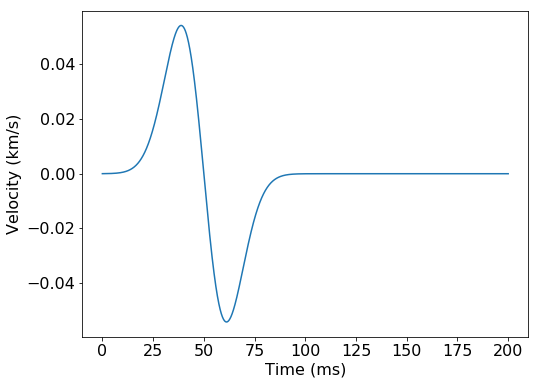

In [3]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1./f0) * np.exp(-a * (t - 1./f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 200.
dt = (1. / np.sqrt(2.)) / 60.
nt = int(1 + (tn-t0) / dt)  # Discrete time axis length
time = np.linspace(t0, tn, nt)  # Discrete modelling time

src = DGaussSource(name='src', grid=grid, f0=0.02, time=time)
src.coordinates.data[:] = [500., 500.]
src.show()

In [4]:
# Cheat-grids for the staggered fields (will be removed eventually)
g_cell = Grid(extent=extent, shape=(11, 11))
g_bottom = Grid(extent=extent, shape=(10, 11))
g_left = Grid(extent=extent, shape=(11, 10))

# Now we create the velocity and pressure fields
u = TimeFunction(name='u', grid=grid)  # The only node-algned field
v = TimeFunction(name='v', grid=grid, staggered=(0, 1, 1))  # Cell-centered

# (I still use y instead of z, because I'm not a geophysicist!)
t_xx = TimeFunction(name='t_xx', grid=grid, staggered=(0, 1, 0))
t_yy = TimeFunction(name='t_yy', grid=grid, staggered=(0, 0, 1))
t_xy = TimeFunction(name='t_xy', grid=grid, staggered=(0, 1, 0))

# Lame parameters
l = Function(name='l', grid=grid, staggered=(1, 0))
mu = Function(name='mu', grid=grid, staggered=(0, 1))

# Buoyancy; should this be allocated on two grids???
b = Function(name='b', grid=grid)

# And finally we create the discretized/indexed symbols
U = u.indexed
V = v.indexed

TXX = t_xx.indexed
TYY = t_yy.indexed
TXY = t_xy.indexed

L = l.indexed
M = mu.indexed
B = b.indexed

In [5]:
# Now let's try and create the staggered updates
x, y = grid.dimensions
t = grid.stepping_dim
time = grid.time_dim

# U^k+1/2:
u_u = Eq(U[t+1, x, y], U[t, x, y] + B[x, y] * t.spacing * (t_xx.dxr + t_yy.dyr))
u_v = Eq(V[t+1, x, y], V[t, x, y] + B[x, y] * t.spacing * (t_yy.dxr + t_xy.dyr))

# I'm not certain about the dicretization of L + 2M
u_txx = Eq(TXX[t+1, x, y], TXX[t, x, y]
           + (L[x, y] + 2*M[x, y]) * t.spacing * (U[t+1, x+1, y] - U[t+1, x, y]) / x.spacing
           + L[x, y] * t.spacing * (V[t+1, x, y+1] - V[t+1, x, y]) / y.spacing)
u_txy = Eq(TXY[t+1, x, y], TXY[t, x, y]
           + (L[x, y] + 2*M[x, y]) * t.spacing * (V[t+1, x, y+1] - V[t+1, x, y]) / y.spacing
           + L[x, y] * t.spacing * (U[t+1, x+1, y] - U[t+1, x, y]) / x.spacing)
u_tyy = Eq(TYY[t+1, x, y], TYY[t, x, y]
           + M[x, y] * t.spacing * (U[t+1, x, y+1] - U[t+1, x, y]) / y.spacing
           + M[x, y] * t.spacing * (V[t+1, x+1, y] - V[t+1, x, y]) / x.spacing)

In [6]:
src_txx = Eq(TXX[t+1, 5, 5], TXX[t+1, 5, 5] + src.indexed[time, 0])
src_txy = Eq(TXY[t+1, 5, 5], TXY[t+1, 5, 5] + src.indexed[time, 0])

In [7]:
op = Operator([u_u, u_v, u_txx, u_txy, u_tyy, src_txx, src_txy], dse=None, dle=None)
#op = Operator([u_u, src_txx, src_txy])

In [8]:
# Force arguments that the engine doesn;t pick up correctly yet
args = {'t': nt, 'time': nt, 'dt':dt, 'x_e': 9, 'y_e':9, 'h_x':100., 'h_y':100.}

# Some useful diagnostics
#print(op.ccode)
#op.arguments(**args)

In [9]:
# We need some initial conditions
V_p = 4.0
V_s = 1.0
density = 3.

# Reset the fields
u.data[:] = 0.
v.data[:] = 0.
t_xx.data[:] = 0.
t_xy.data[:] = 0.
t_yy.data[:] = 0

b.data[:] = 1./density
l.data[:] = density * (V_p**2 - V_s**2)
mu.data[:] = density * V_s**2

op(**args)

CustomCompiler: compiled /tmp/devito-1tk3bv9u/dff9e53830395da3dacb323f7abbc758a9494111.c [0.13 s]
Section section_0<16971,9,9> with OI=0.81 computed in 0.000 s [71481.85 GFlops/s]
Section main<16971> with OI=0.96 computed in 0.075 s [0.01 GFlops/s, 0.00 GPts/s]


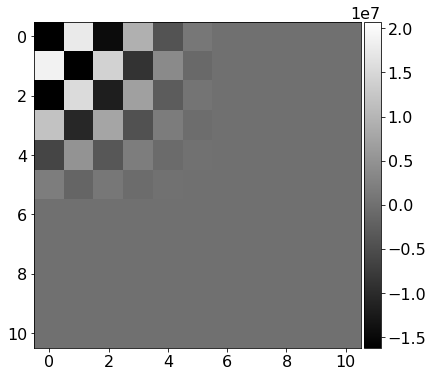

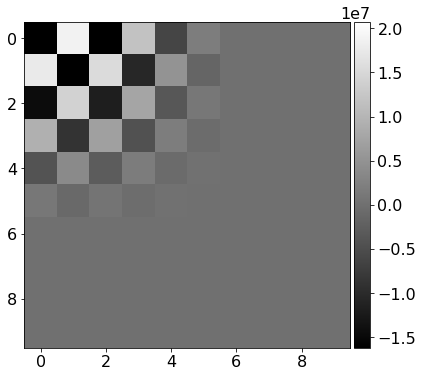

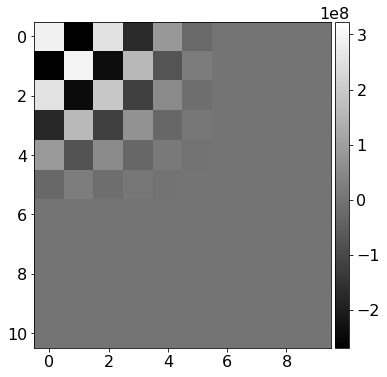

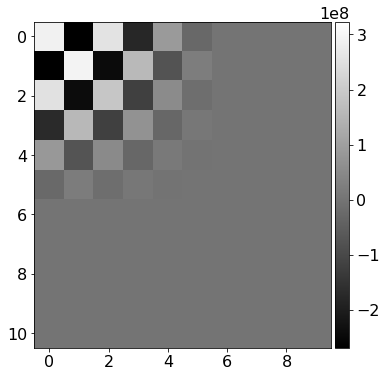

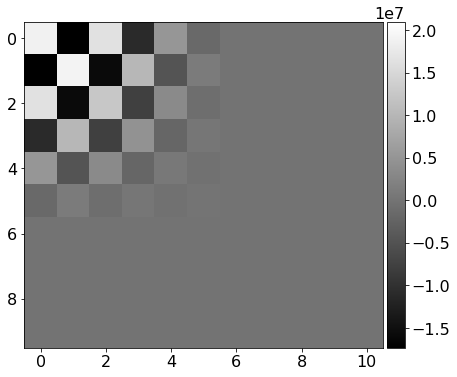

In [10]:
# Let's see what we got....
plot_image(u.data[0])
plot_image(v.data[0])
plot_image(t_xx.data[0])
plot_image(t_xy.data[0])
plot_image(t_yy.data[0])